# Testing ECG data with LAP:

In [1]:
output_path = './outputs/graphs/'
results_path = 'outputs/ecg_results/'

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import graph_code.graphing_utils as plotting

In [3]:
colwidth = 4.22716535
pagewidth = 8.7598425

In [4]:
results_list = []
corruption_levels = []
for file in [
    f for f in os.listdir(results_path) if f.endswith("json")
]:
    with open(results_path + file) as f:
        results_temp = json.load(f)
    results_list.append(results_temp)
    corruption_level = float(file.split(".json")[0].split("_")[-2])
    corruption_levels.append(corruption_level)

In [5]:
results = {}

for results_dict, c_level in zip(results_list, corruption_levels):
    if c_level not in results:
        results[c_level] = {}
    
    for dataset in results_dict:
        if dataset not in results[c_level]:
            results[c_level][dataset] = {}
       
        for nc in results_dict[dataset]:
            if nc not in results[c_level][dataset]:
                results[c_level][dataset][nc] = {}
            
            for run in results_dict[dataset][nc]:
                if run not in results[c_level][dataset][nc]:
                    results[c_level][dataset][nc][run] = {}

                for depression in results_dict[dataset][nc][run]:

                    results[c_level][dataset][nc][run][depression] = [
                        dict(epoch=int(epoch), **metrics) 
                        for epoch, metrics in results_dict[dataset][nc][run][depression].items() 
                        if epoch != 'corrupt_sources'
                    ]

In [6]:
results_df = []

for c_level in results:
    for dataset in results[c_level]:
        for nc in results[c_level][dataset]:
            for run in results[c_level][dataset][nc]:
                for depression in results[c_level][dataset][nc][run]:
                    results_df.append(
                        pd.json_normalize(
                            results[c_level][dataset][nc][run][depression]
                        )
                        .assign(
                            dataset=dataset,
                            n_corrupt_sources=nc,
                            run=run,
                            corruption_level=c_level,
                            depression=depression
                        )
                        .assign(epoch=lambda x: x['epoch']+1)
                    )
results_df = pd.concat(results_df)
results_df = (
    results_df
    .replace({"depression": {"true": True, "false": False}})
    .astype(
        {
            "n_corrupt_sources": "int64",
            "run": "int64",
            "depression": "bool",
        }
    )
    .loc[
        lambda df: df["n_corrupt_sources"] <= 8
    ]
)

In [7]:
results_df['run'].unique()

array([1, 2, 3, 4, 5])

In [8]:
results_df = results_df.melt(
    id_vars=['dataset', 'n_corrupt_sources', 'run', 'depression', 'epoch'],
    var_name='metric',
    value_name='value'
)

In [9]:
results_df

,dataset,n_corrupt_sources,run,depression,epoch,metric,value
0,ptb_xl,2,1,True,1,train_loss,0.430401
1,ptb_xl,2,1,True,2,train_loss,0.278600
2,ptb_xl,2,1,True,3,train_loss,0.239591
3,ptb_xl,2,1,True,4,train_loss,0.213343
4,ptb_xl,2,1,True,5,train_loss,0.206689
...,...,...,...,...,...,...,...
47595,ptb_xl,8,5,False,36,corruption_level,0.250000
47596,ptb_xl,8,5,False,37,corruption_level,0.250000
47597,ptb_xl,8,5,False,38,corruption_level,0.250000
47598,ptb_xl,8,5,False,39,corruption_level,0.250000


In [10]:
(
    results_df
    .loc[lambda df: df.metric == 'test_AUC PR']
    .groupby(["n_corrupt_sources", "depression", "run"])
    [['value']]
    .max()
    .reset_index()
    .groupby(["n_corrupt_sources", "depression"])
    ['value']
    .agg(['mean', 'std'])
    .assign(
        mean_std = lambda x: 
            np.round(x['mean'], 3).astype(str) 
            + " ± "
            + np.round(x['std'], 3).astype(str),
    )
    ['mean_std']
    .unstack('depression')
    .rename_axis(None, axis=1)
)

,False,True
n_corrupt_sources,,
2,0.945 ± 0.001,0.944 ± 0.001
3,0.94 ± 0.001,0.943 ± 0.003
4,0.938 ± 0.002,0.942 ± 0.003
5,0.934 ± 0.002,0.943 ± 0.002
6,0.927 ± 0.006,0.938 ± 0.002
7,0.922 ± 0.007,0.936 ± 0.003
8,0.914 ± 0.008,0.938 ± 0.005


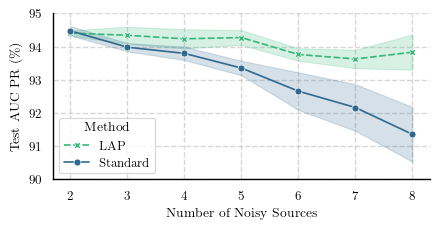

In [11]:
with plotting.paper_theme():
    plt.close()

    fig, ax = plt.subplots(figsize=(colwidth, 0.5*colwidth))

    ax = sns.lineplot(
        data=(
            results_df
            .loc[lambda df: df.metric == 'test_AUC PR']
            .groupby(["n_corrupt_sources", "depression", "run"])
            [['value']]
            .max()
            .reset_index()
            .replace({"depression": {True: "LAP", False: "Standard"}})
        ),
        x="n_corrupt_sources",
        y="value",
        hue="depression",
        style="depression",
        palette=sns.color_palette(plotting.palette, 2)[::-1],
        hue_order=["LAP", "Standard"],
        markers=['o', 'X'],
        markersize=5,
        markeredgewidth=0.5,
        ax=ax,
        errorbar='sd',
    )

    ax.set_ylim(0.9, 0.95)
    yloc = mpl.ticker.MaxNLocator(5, steps=[5, 10])
    yformat = mpl.ticker.FuncFormatter(lambda x, pos: f"{x*100 : .0f}%")

    ax.yaxis.set_major_locator(yloc)
    ax.yaxis.set_major_formatter(yformat)

    xloc = mpl.ticker.MultipleLocator(base=1)

    ax.xaxis.set_major_locator(xloc)

    ax.set_xlabel("Number of Noisy Sources")
    ax.set_ylabel("Test AUC PR (\%)")
    #ax.set_title("PTB-XL Performance")

    sns.move_legend(ax, title="Method", loc="lower left")
    
    fig.subplots_adjust(top=0.98, bottom=0.195, left=0.105, right=0.995)

    plotting.save_fig(
        fig, output_path + "ptbxl_aucpr_vs_corruption"
    )


    plt.show()